In [32]:
import sys

sys.path.append('..')


from pychord_tools.low_level_features import  AnnotatedBeatChromaEstimator
from pychord_tools.third_party import NNLSChromaEstimator
from pychord_tools.labels import DEGREES
from pychord_tools import plots
from pychord_tools.plots import ternary_plot, plot_labels

from pychord_tools.compositional_data import substitute_zeros, amalgamate, alrinv
from simmusic.feature_extraction import AdaptiveChromaEstimator, GuitarLabelTranslator

from test_code.test_utils.training_individual_chord_model import NewModel,SimUidAndAudioPathExtractor
from test_code.Training_Model import BASE_PATH, append_to_segments, load_segments_for_trainning

import joblib
import numpy as np

# Install if not
from sklearn import preprocessing
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

store =        BASE_PATH + '/test_code/test_utils/models/'

In [2]:
# load data
annotations = ['/test_data/Lily Was Here/Lily Was Here.json',
               '/test_data/Hole In My Shoe/Hole In My Shoe.json',
               '/test_data/20th Century Boy/20th Century Boy.json',
               '/test_data/Where Did You Sleep Last Night/Where Did You Sleep Last Night.json',
               '/test_data/Runaway Train/Runaway Train.json']
annotations = [ BASE_PATH + x for x in annotations]


segments = load_segments_for_trainning(annotations)

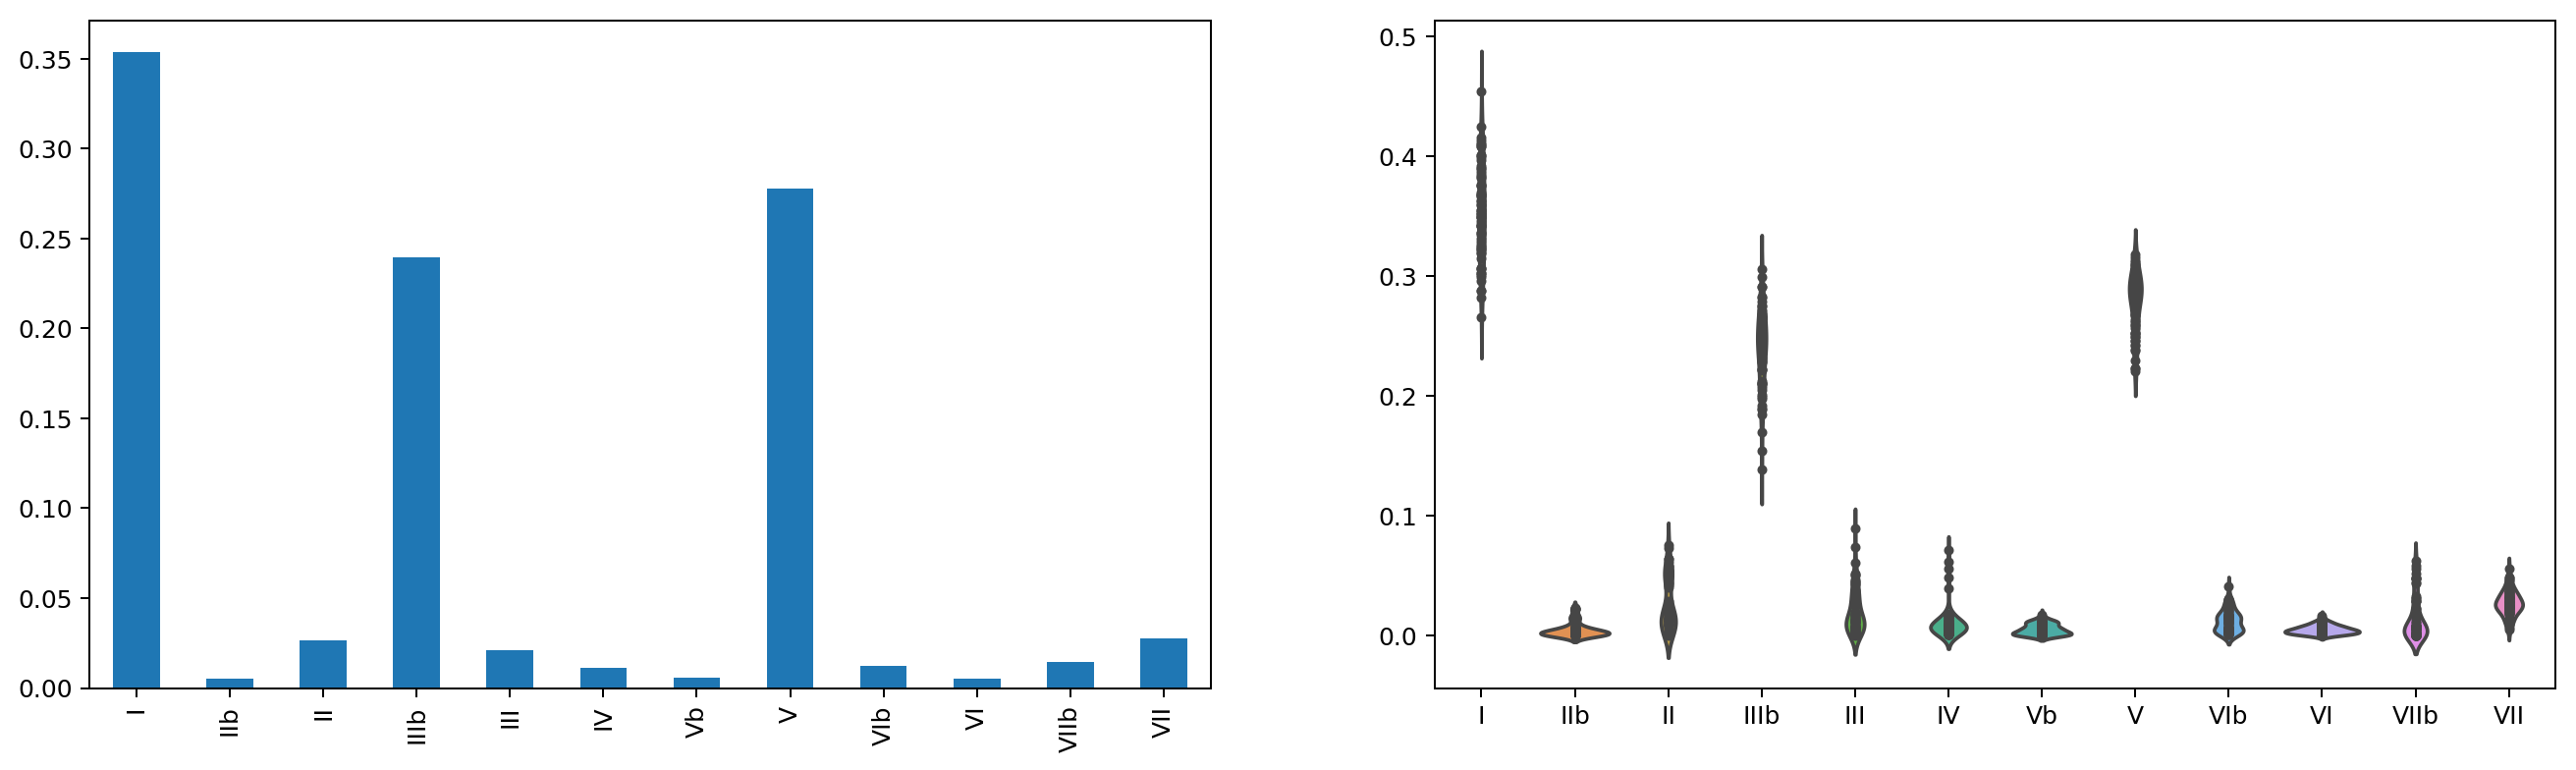

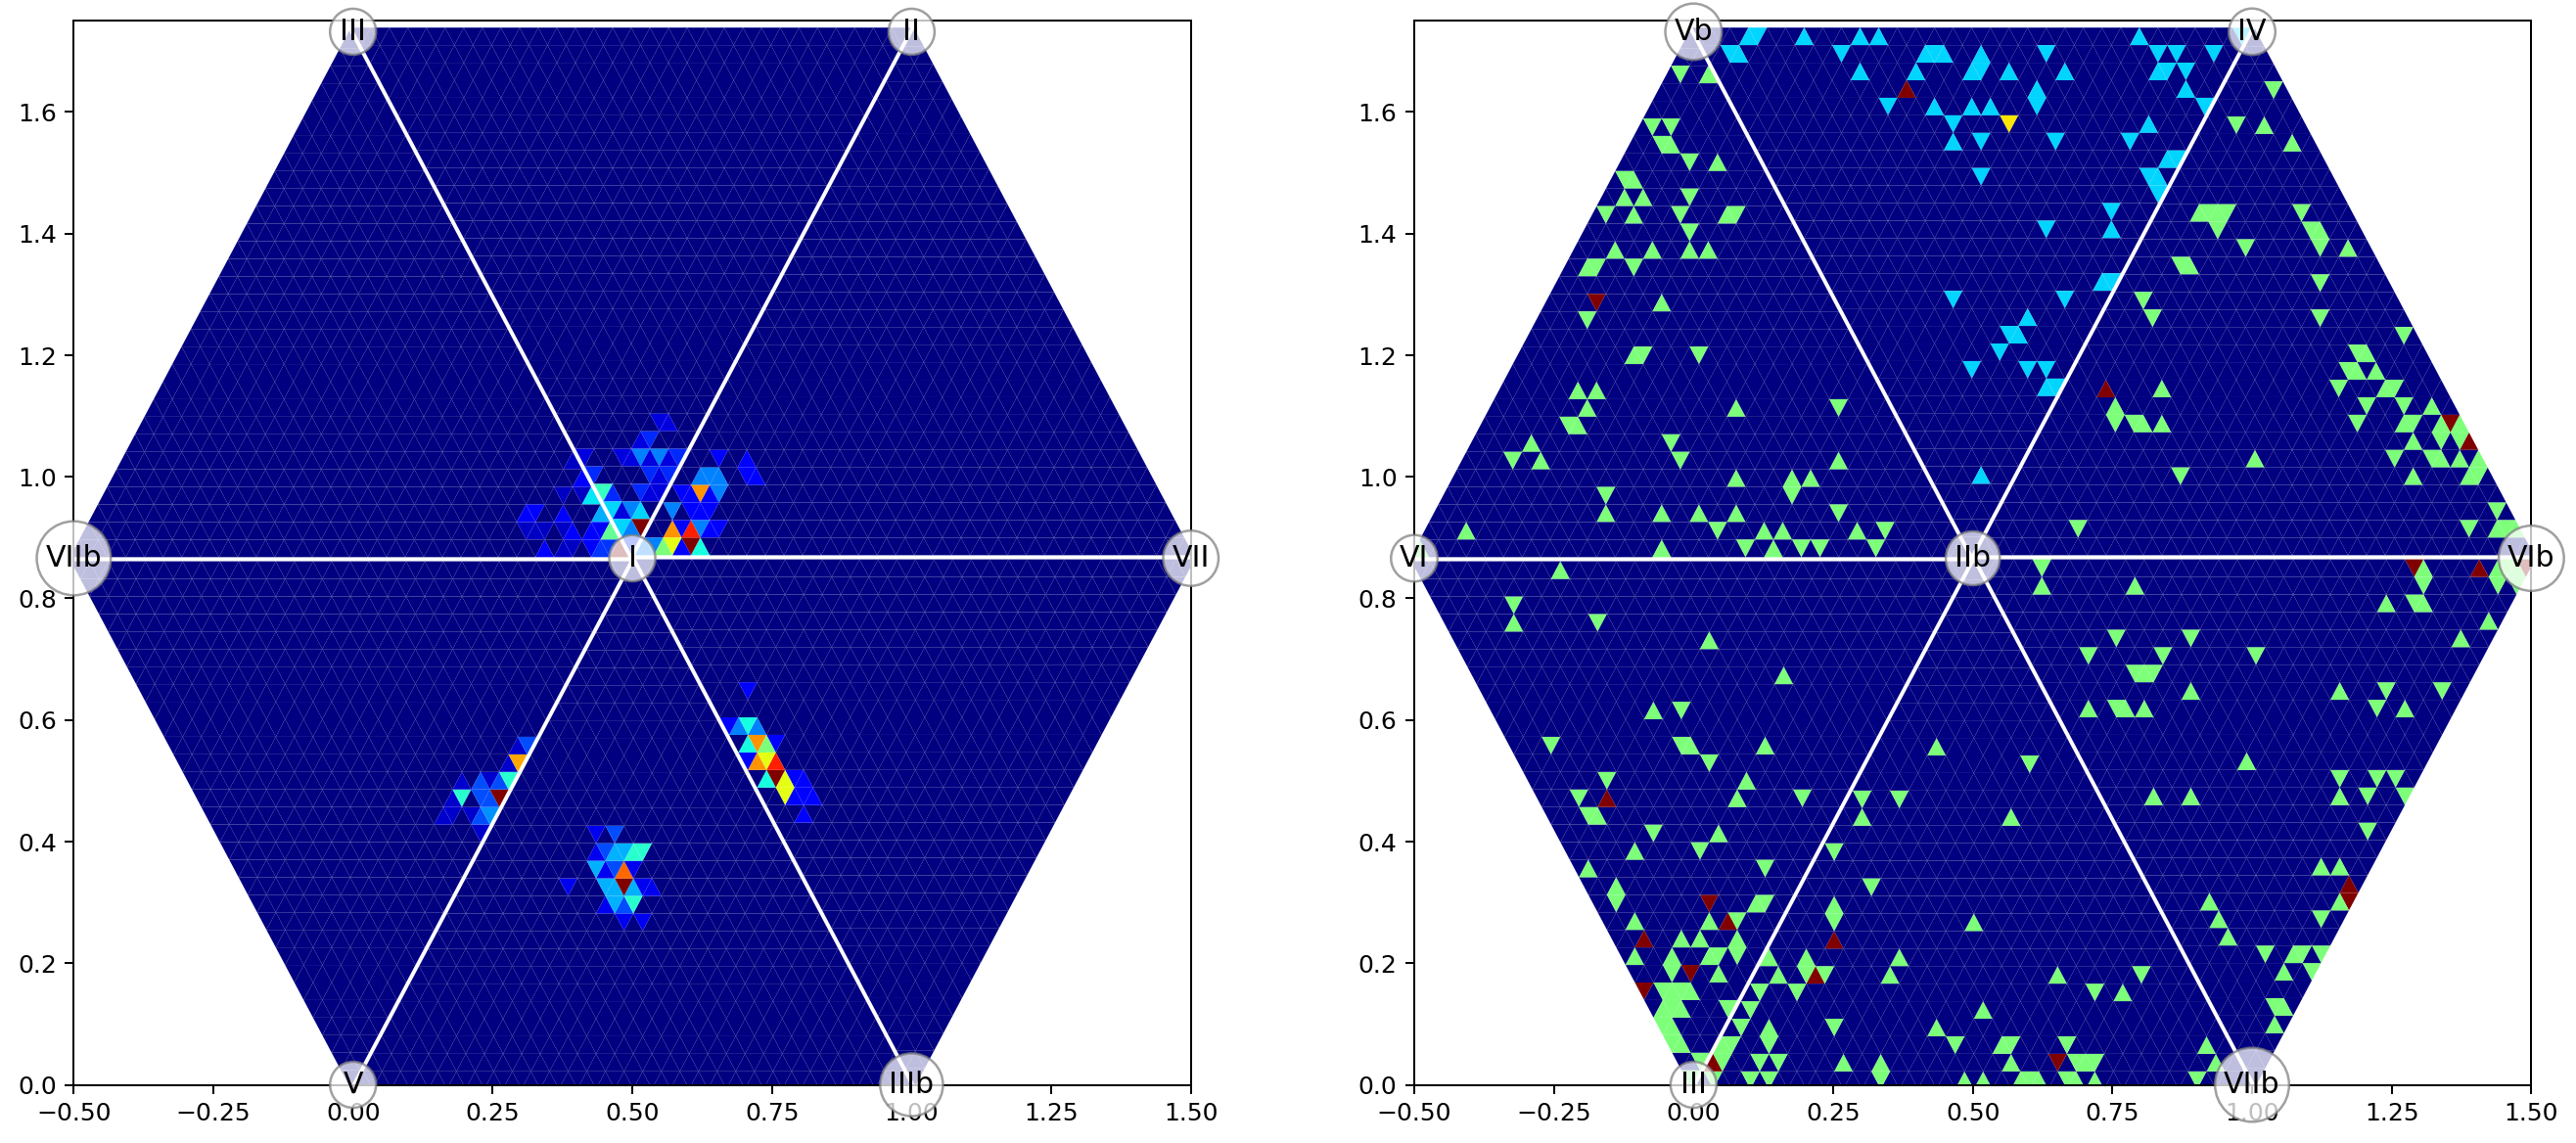

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  3., 15., 29., 21.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

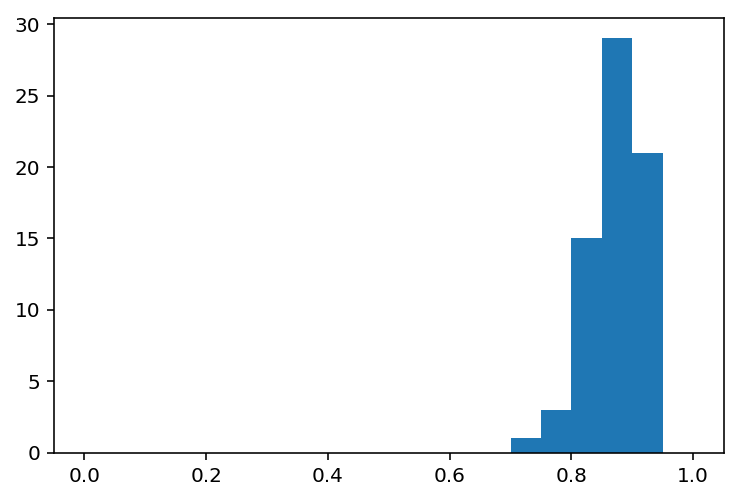

In [3]:
segments = load_segments_for_trainning(annotations)
single_chord = preprocessing.normalize(substitute_zeros(segments.chromas[segments.kinds == 'min']), norm='l1')
dframe = pd.DataFrame(data=single_chord,  columns=DEGREES)

# Marginal degrees distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), dpi= 90, facecolor='w', edgecolor='k')

m = np.mean(dframe)
m.plot(kind='bar', ax=ax[0])

sns.violinplot(data=dframe, inner="point", axes=ax[1])

# joint degrees distribution

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), dpi= 90, facecolor='w', edgecolor='k')
sorted_degrees = plots.sorted_degrees(single_chord, flip=True)
plots.plot_strong_weak_hexagrams(ax[0], ax[1], single_chord, sorted_degrees)
plt.show()

# Strong/weak ratio
partition = [
    [DEGREES.index('I'), DEGREES.index('IIIb'), DEGREES.index('V')],
    [DEGREES.index('II'), DEGREES.index('VII'), DEGREES.index('IIb'), DEGREES.index('III'), DEGREES.index('IV'),
     DEGREES.index('Vb'), DEGREES.index('VIb'), DEGREES.index('VI'), DEGREES.index('VIIb')]]
chord_ratio = amalgamate(partition, single_chord).transpose()[0]
plt.hist(chord_ratio, range=(0,1), bins=20)

In [4]:
sorted_degrees

array(['I', 'V', 'IIIb', 'VII', 'II', 'III', 'VIIb', 'VIb', 'IV', 'Vb',
       'VI', 'IIb'], dtype=object)

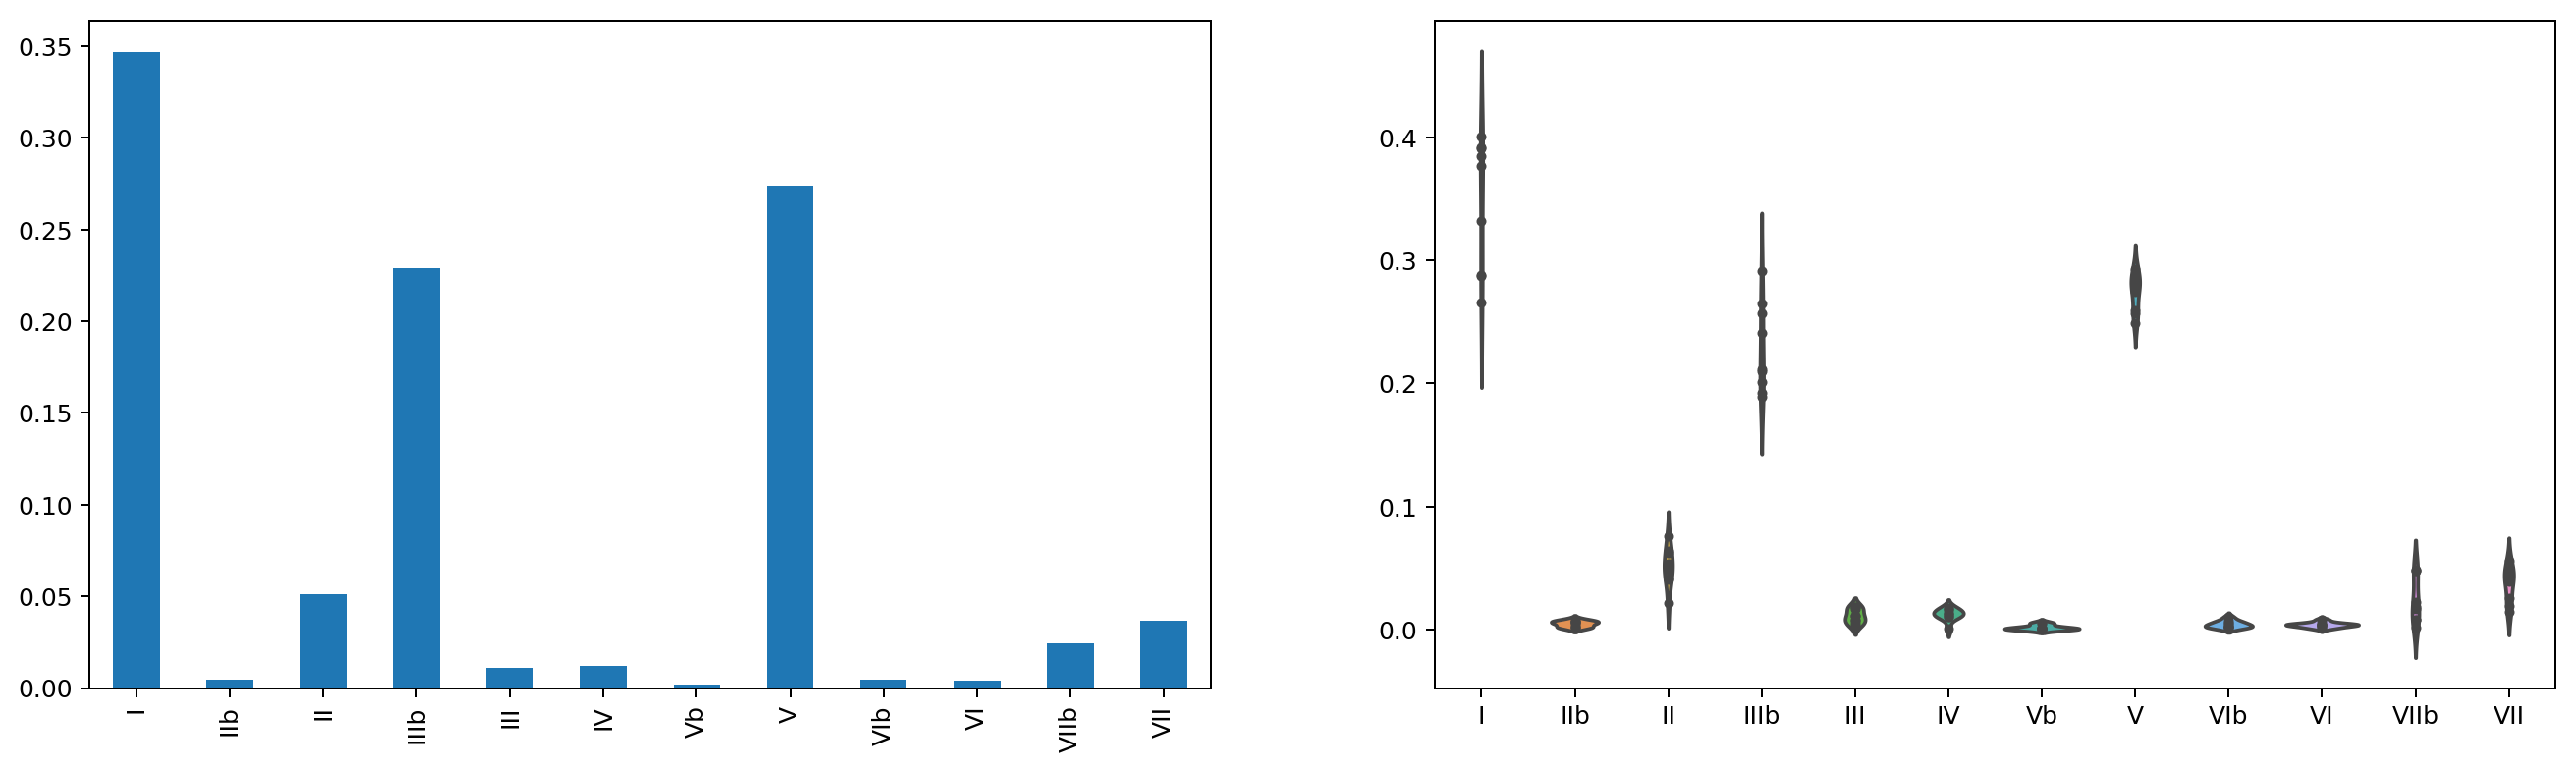

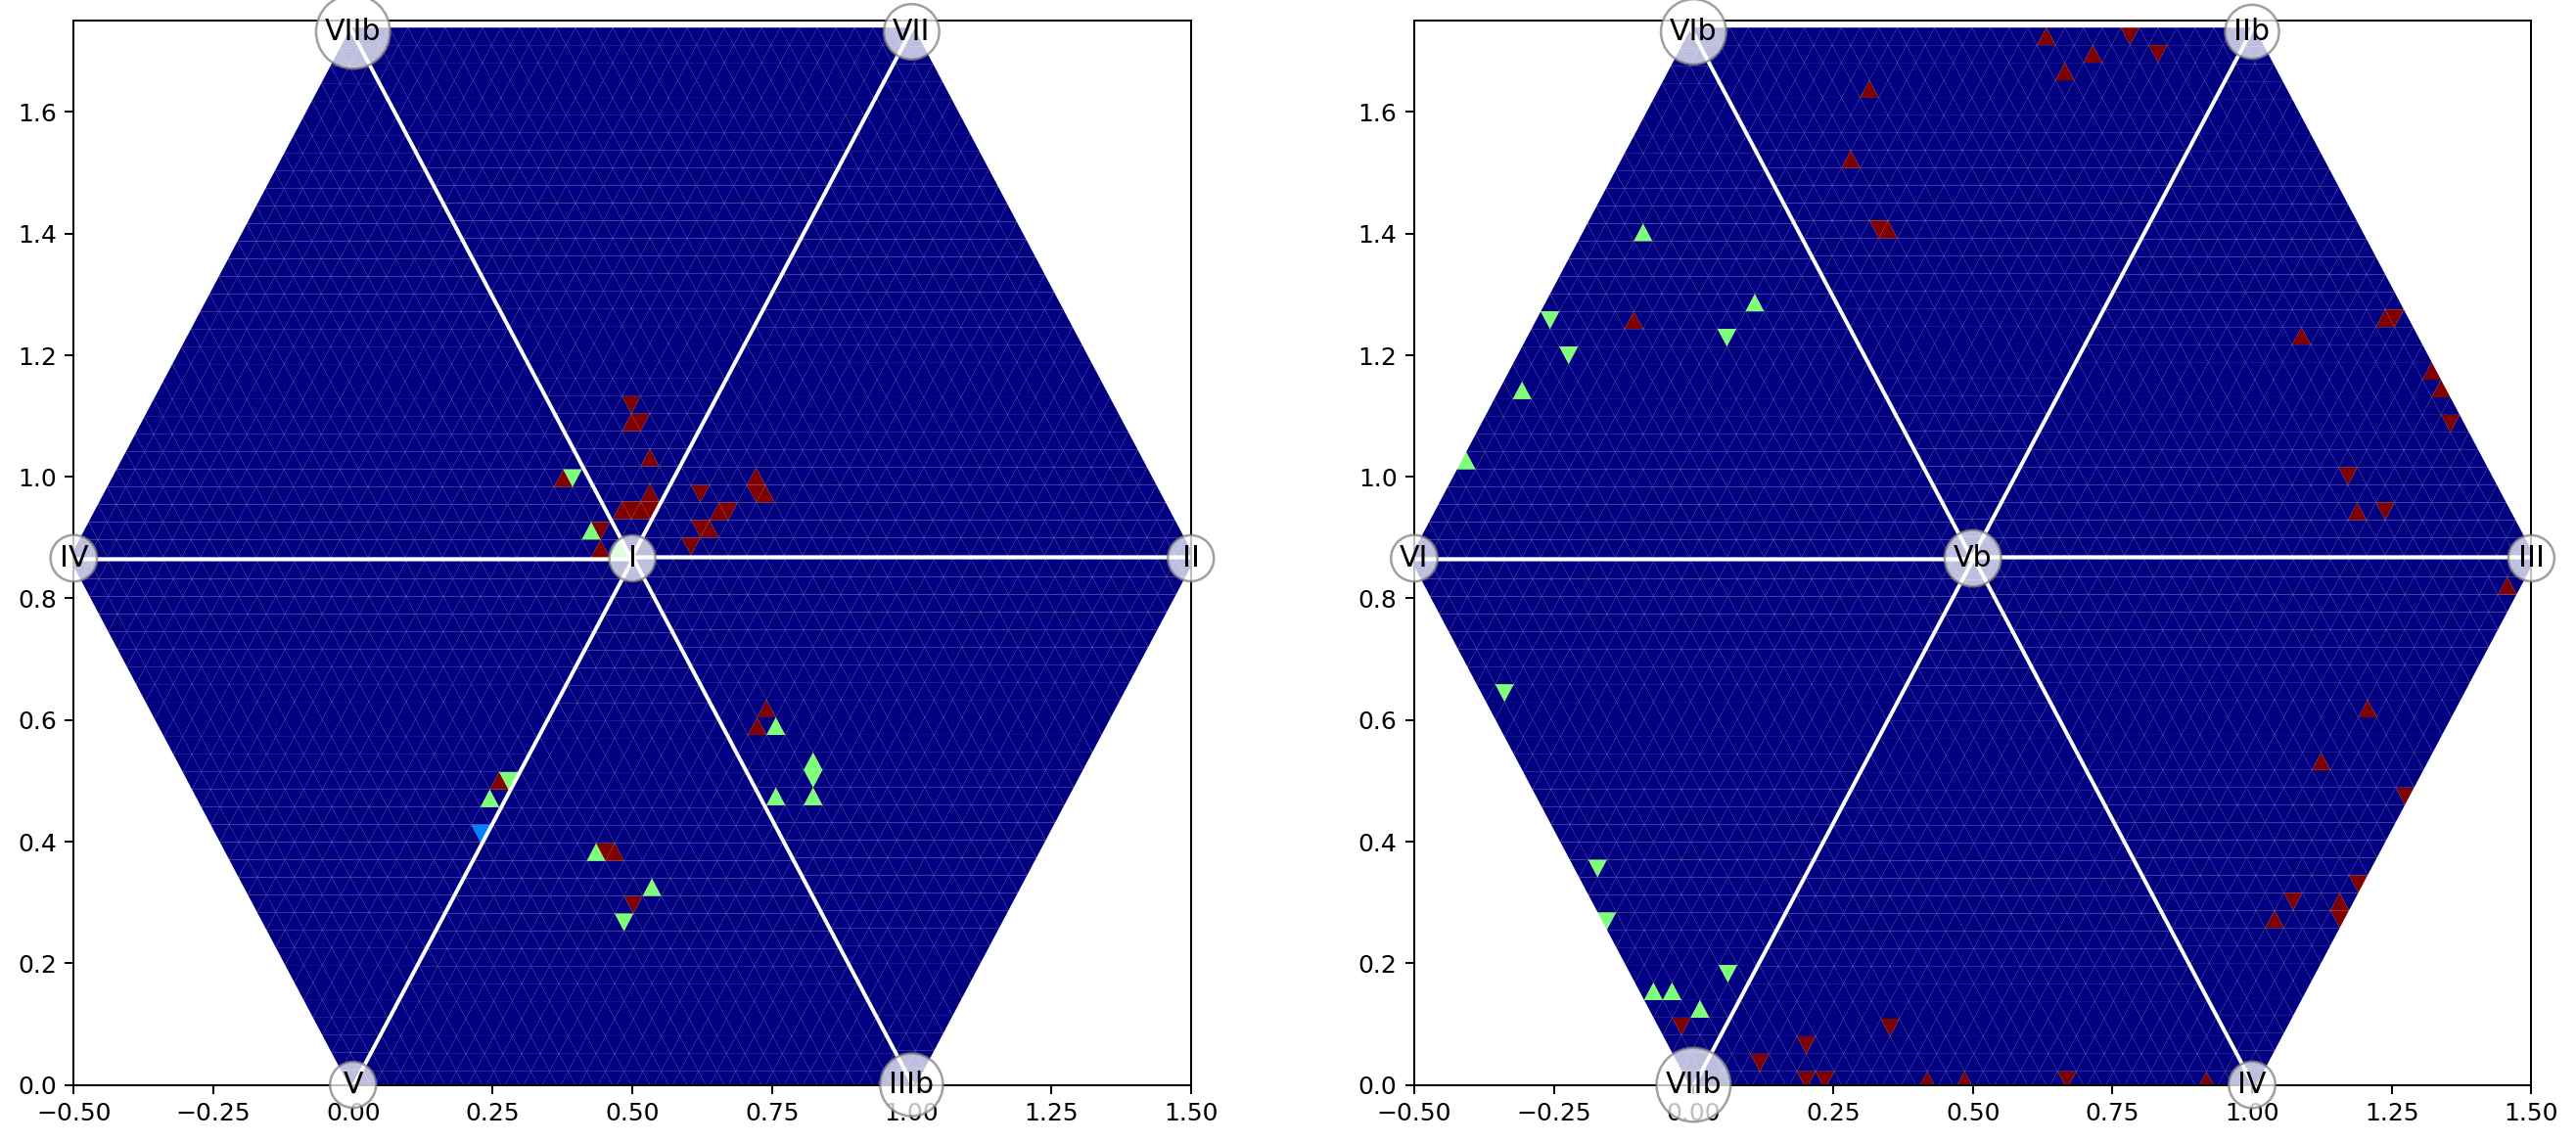

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
        6., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

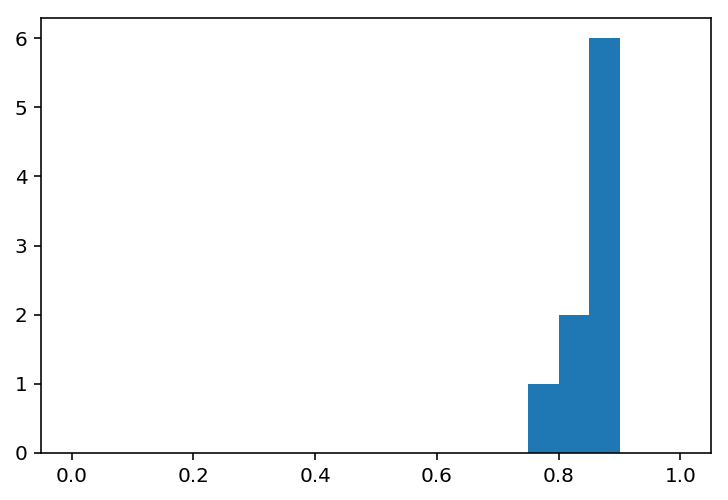

In [5]:
annotations = ['/test_data/Lily Was Here/Lily Was Here.json']
annotations = [ BASE_PATH + x for x in annotations]
segments = load_segments_for_trainning(annotations)

single_chord = preprocessing.normalize(substitute_zeros(segments.chromas[segments.kinds == 'min']), norm='l1')
dframe = pd.DataFrame(data=single_chord,  columns=DEGREES)

# Marginal degrees distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), dpi= 90, facecolor='w', edgecolor='k')

m = np.mean(dframe)
m.plot(kind='bar', ax=ax[0])

sns.violinplot(data=dframe, inner="point", axes=ax[1])

# joint degrees distribution

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), dpi= 90, facecolor='w', edgecolor='k')
sorted_degrees = plots.sorted_degrees(single_chord, flip=True)
plots.plot_strong_weak_hexagrams(ax[0], ax[1], single_chord, sorted_degrees)
plt.show()

# Strong/weak ratio
partition = [
    [DEGREES.index('I'), DEGREES.index('IIIb'), DEGREES.index('V')],
    [DEGREES.index('II'), DEGREES.index('VII'), DEGREES.index('IIb'), DEGREES.index('III'), DEGREES.index('IV'),
     DEGREES.index('Vb'), DEGREES.index('VIb'), DEGREES.index('VI'), DEGREES.index('VIIb')]]
chord_ratio = amalgamate(partition, single_chord).transpose()[0]
plt.hist(chord_ratio, range=(0,1), bins=20)

In [6]:
sorted_degrees

array(['I', 'V', 'IIIb', 'II', 'VII', 'VIIb', 'IV', 'III', 'IIb', 'VIb',
       'VI', 'Vb'], dtype=object)

In [7]:
# Model

In [82]:
def visualize(model, k, n_samples=1000):
  """
  Works only for 2-3 in_degrees. Require some improvements for other quantities.
  """
  kind = m.kinds[k]
  b=m.betas[kind]
  gm = m.balanceGMMs[kind]
  in_degrees = np.array(DEGREES)[m.in_degree_dict[kind]]
  fig, ax = plt.subplots(1,2)
  ax[0].hist(b.rvs(n_samples), range=(0, 1))
  ax[0].set_title(kind + " In-chord/out-chord ratio")
  gen = gm.sample(n_samples)
  genChroma = np.apply_along_axis(alrinv, 1, gen[0])
  ax[1].set_title(kind + " Balance")
  if (len(in_degrees) == 3):
    ternary_plot(ax[1], genChroma, 36)
    plot_labels(ax[1], in_degrees)
  elif (len(in_degrees) == 2):
    ax[1].hist(genChroma[:,0], range=(0, 1))

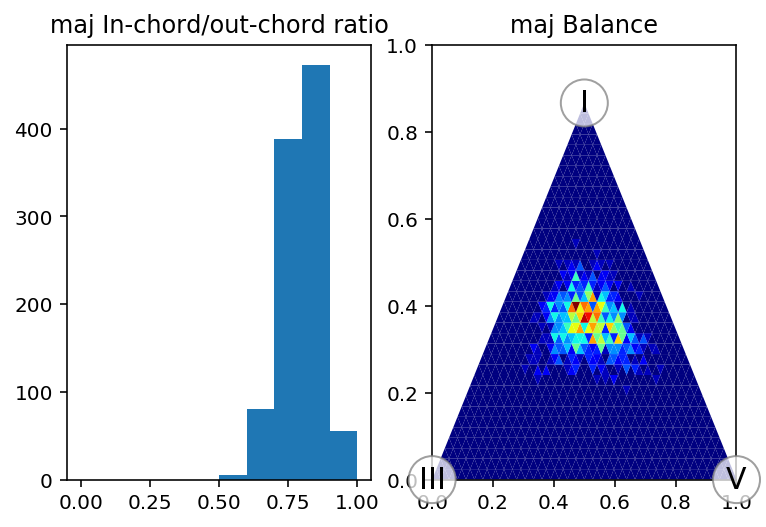

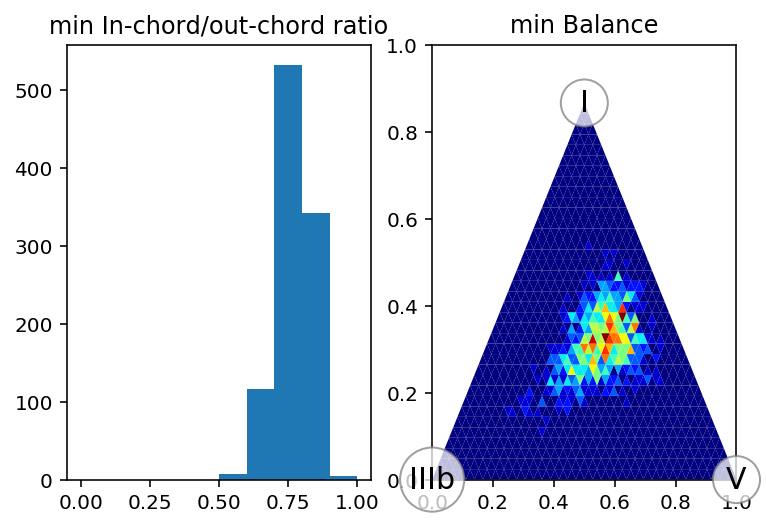

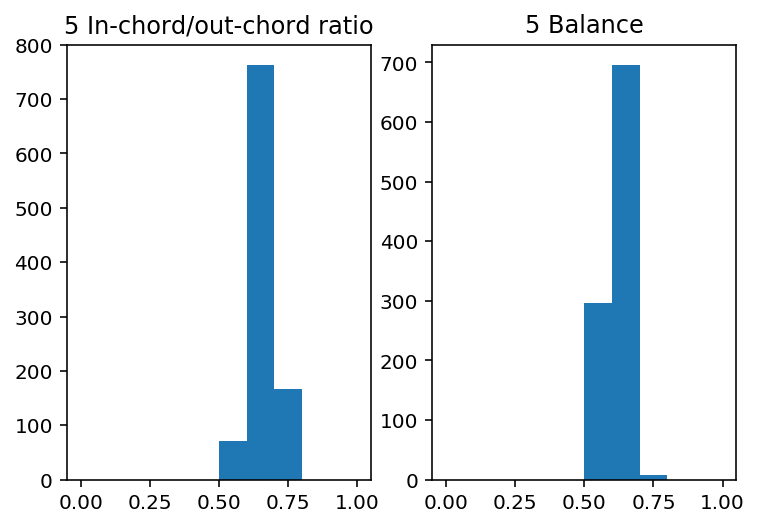

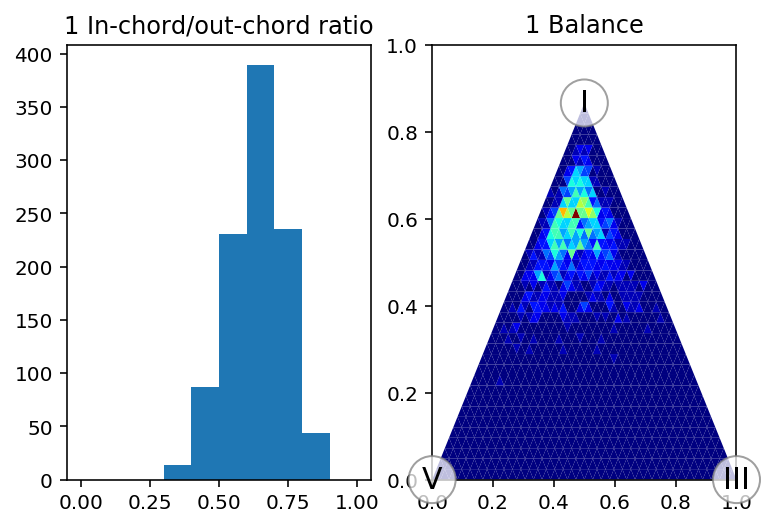

In [83]:
model = 'test_utils/models/new_model.pkl'
m =  joblib.load(open(model, 'rb'))
for k in range(len(m.kinds)):
  visualize(m, k)

In [8]:
# Point over Model